# Dependencies

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(tf.__version__)
############ settings ############
data_dir = r"training"

batch_size = 32
img_height = 128
img_width = 128

2.12.0


import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils



def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	
if __name__ == "__main__":
	training = "dataset/Training"
	testing = "dataset/Testing"
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)
	
	for dir in testing_dir:
		save_path = 'cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

# Data preprocessing

**- Loading and splitting data<br>**
**- Train:80% and Validation:20%**

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,

    validation_split=0.2,

    subset="training",

    seed=123,

    image_size=(img_height, img_width),

    batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,

    validation_split=0.2,

    subset="validation",

    seed=123,

    image_size=(img_height, img_width),

    batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


# EDA

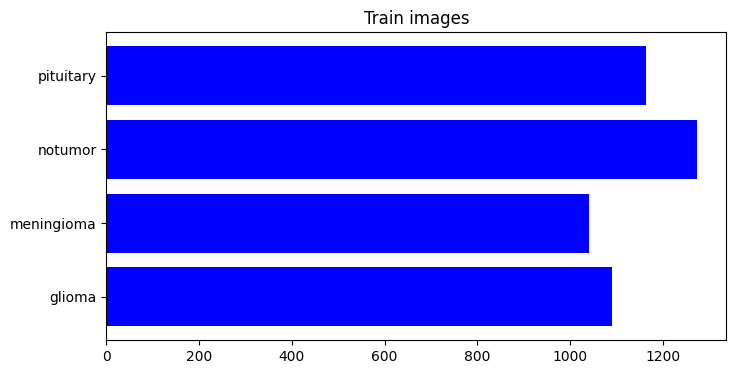

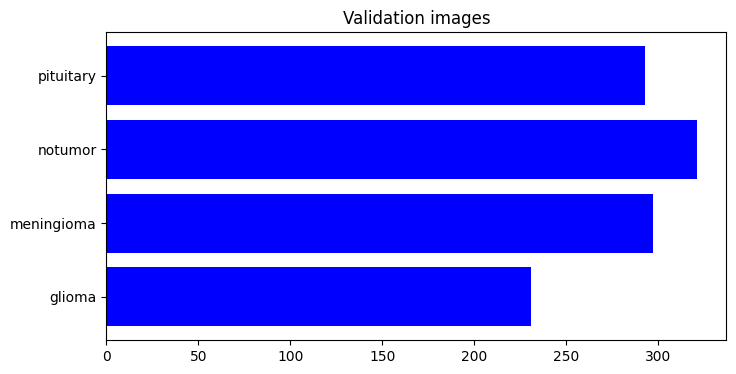

In [3]:
def plot_distribution(y, title):
    a = Counter(y)
    y = ['glioma', 'meningioma', 'notumor','pituitary']

    x = [a[i] for i in range(4)]
    plt.figure(figsize=(8, 4))
    plt.barh(y, x, color='blue')
    plt.title(title)
    return plt.show()


y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title="Validation images")

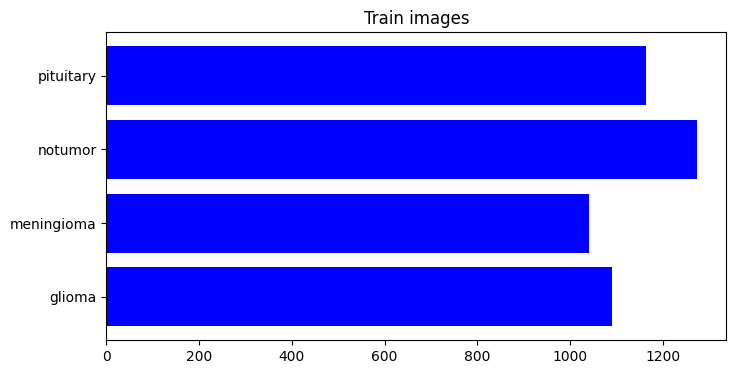

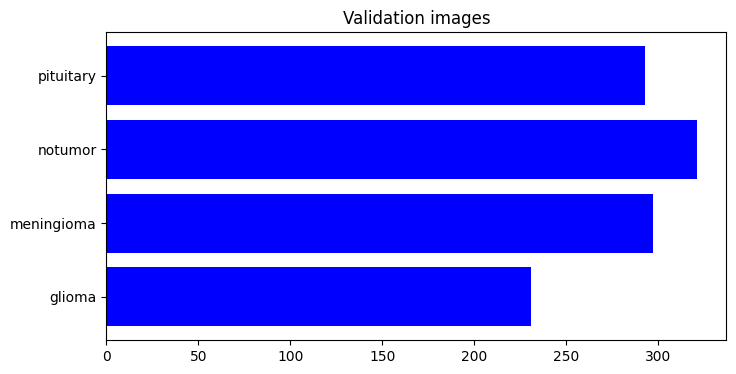

In [4]:
# Target distribution

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title="Validation images")

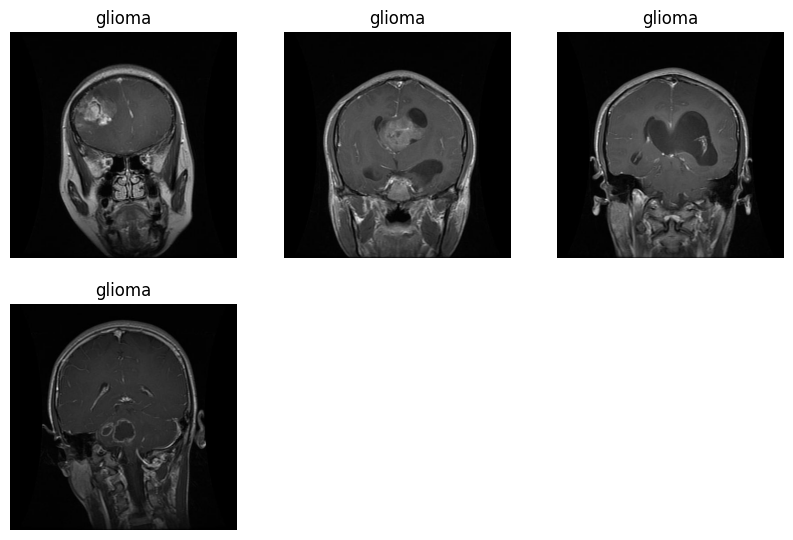

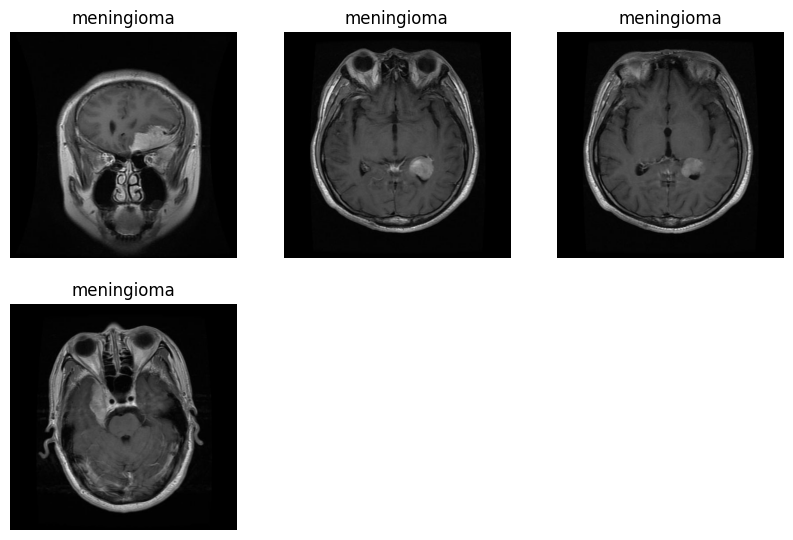

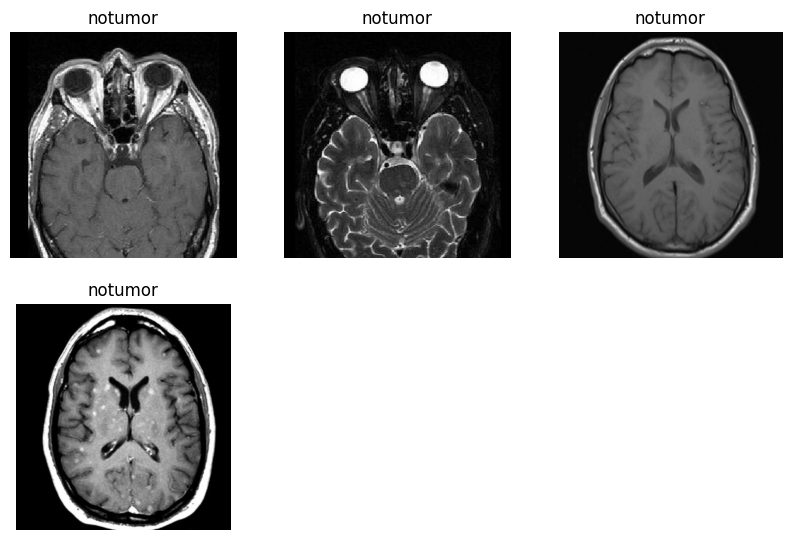

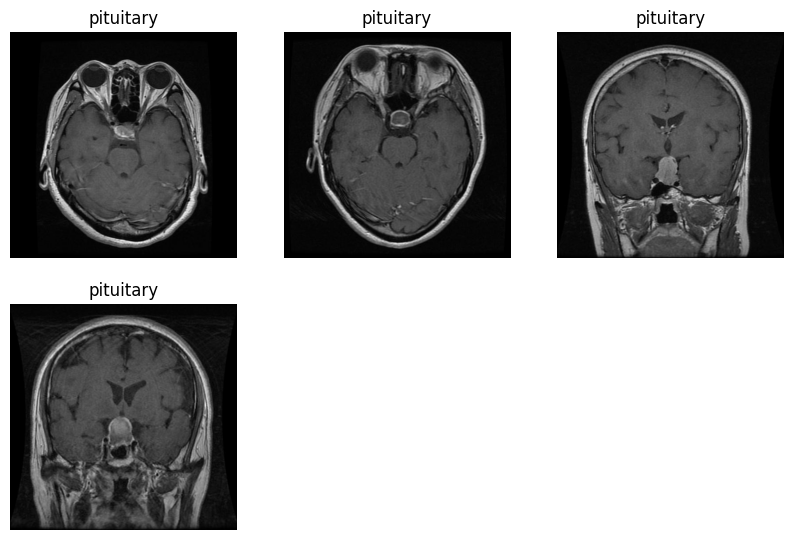

In [5]:
# Sample images
class_names = train_ds.class_names

for class_name in class_names:
    imgs = os.listdir(os.path.join(data_dir, class_name))[:4]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(plt.imread(os.path.join(data_dir, class_name, img)))
        plt.title(class_name)
        plt.axis('off')

In [6]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model architecture - Fusing ResNet-101 with additional CNN layers
num_classes = 4  # Update the number of classes to match your dataset

# Create ResNet-101 model with pre-trained ImageNet weights
base_model = tf.keras.applications.ResNet101(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained ResNet-101 model
base_model.trainable = False

# Building the fused model
model = tf.keras.Sequential([
    base_model,
    # Add custom CNN layers
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Add another CNN layer
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling and dense layers
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    
    # Output layer
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 64)          1179712   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 128)        0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 128)              0

In [8]:

# Early stopping callback
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)

In [9]:
# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    callbacks=[earlystop_callback])

Epoch 1/5


143/143 [==============================] - 176s 1s/step - loss: 0.6277 - accuracy: 0.7847 - val_loss: 0.2853 - val_accuracy: 0.8914
Epoch 2/5
143/143 [==============================] - 165s 1s/step - loss: 0.2674 - accuracy: 0.9042 - val_loss: 0.2223 - val_accuracy: 0.9247
Epoch 3/5
143/143 [==============================] - 164s 1s/step - loss: 0.1839 - accuracy: 0.9344 - val_loss: 0.2978 - val_accuracy: 0.9194
Epoch 4/5
143/143 [==============================] - 164s 1s/step - loss: 0.1370 - accuracy: 0.9508 - val_loss: 0.2132 - val_accuracy: 0.9352
Epoch 5/5
143/143 [==============================] - 161s 1s/step - loss: 0.1024 - accuracy: 0.9691 - val_loss: 0.2245 - val_accuracy: 0.9273


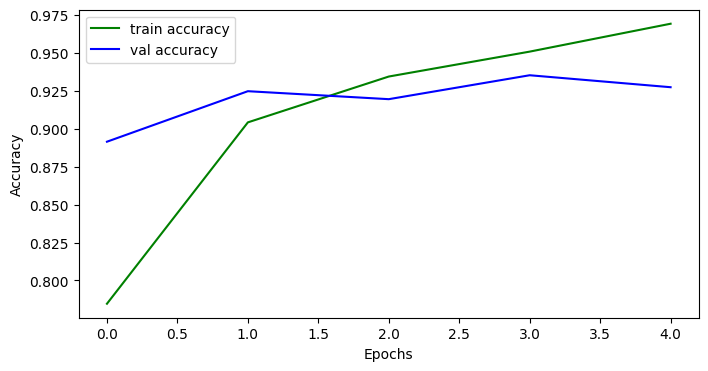

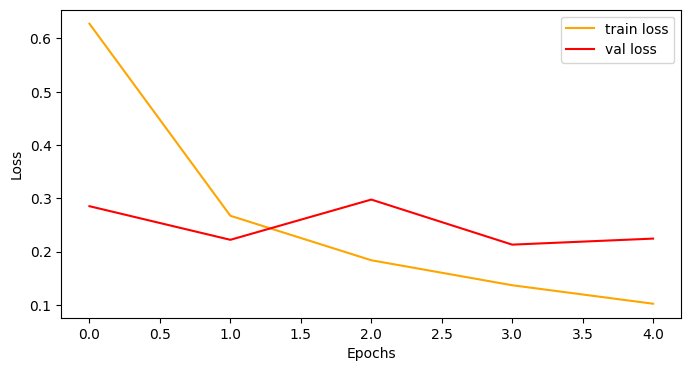

In [10]:

# Plot accuracy and loss
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']

# Accuracy plots
plt.figure(figsize=(8, 4))
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 4))
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Evaluate the model
loss, acc = model.evaluate(val_ds, batch_size=batch_size)
print("Validation accuracy:", round(acc, 2))
print("Validation loss:", round(loss, 2))

# Confusion matrix
y_pred = []  # store predicted labels
y_true = []  # store true labels

# Iterate over the dataset
for image_batch, label_batch in val_ds:
    # Append true labels
    y_true.append(label_batch)
    # Compute predictions
    preds = model.predict(image_batch)
    # Append predicted labels
    y_pred.append(np.argmax(preds, axis=-1))




36/36 [==============================] - 32s 880ms/step - loss: 0.2245 - accuracy: 0.9273
Validation accuracy: 0.93
Validation loss: 0.22
1/1 [==============================] - 2s 2s/step


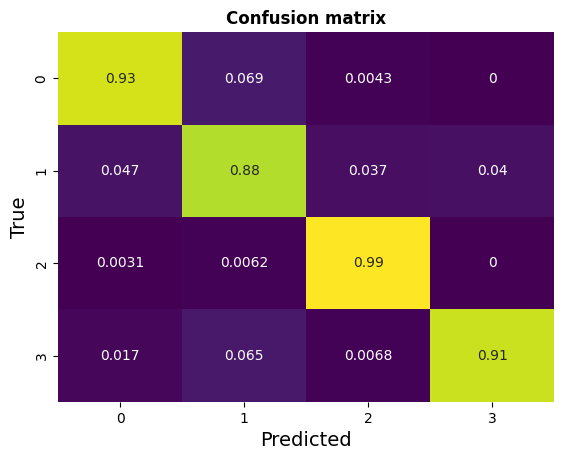

In [12]:
# Convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [13]:
# Additional imports for metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute accuracy, precision, recall, and F1 score
y_pred = []  # store predicted labels
y_true = []  # store true labels

# Iterate over the validation dataset
for image_batch, label_batch in val_ds:
    # Append true labels
    y_true.append(label_batch)
    # Compute predictions
    preds = model.predict(image_batch)
    # Append predicted labels
    y_pred.append(np.argmax(preds, axis=-1))

# Flatten the arrays to get them into a single list
y_true = tf.concat([item for item in y_true], axis=0).numpy()
y_pred = tf.concat([item for item in y_pred], axis=0).numpy()

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")


1/1 [==============================] - 1s 653ms/step
Accuracy: 0.9273
Precision (weighted): 0.9274
Recall (weighted): 0.9273
F1 Score (weighted): 0.9271


In [14]:
model.save("resnet101_cnn_model.h5")

In [15]:
def prediction(img):
    class_names = ['glioma', 'meningioma', 'notumor','pituitary']

    my_image = load_img(img, target_size=(img_height, img_width))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',
             edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2,3], labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

1/1 [==============================] - 0s 75ms/step


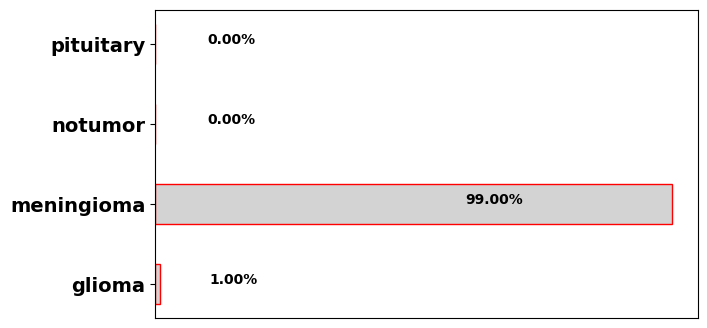

In [19]:
img = 'Tr-me_0010.JPG'
prediction(img)